In [ ]:
!git clone https://github.com/Azzam-Radman/Toxic-Spans-Detection.git

In [1]:
# import libraries
import pandas as pd
import numpy as np
from ast import literal_eval
pd.set_option('display.max_colwidth', None)

import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval

from sklearn.model_selection import StratifiedKFold
# BiLSTM
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import (LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Flatten, Dropout, 
                                     Input, Add, Concatenate, RepeatVector, Lambda, Multiply, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import load_model
from nltk.tokenize import TweetTokenizer
import numpy as np
import spacy

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from nltk.corpus import stopwords
import re

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 2.0 MB/s eta 0:00:01


In [3]:
# read the datasets
try:
    # will be implimented if the repo is cloned
    df1 = pd.read_excel('/content/Toxic-Spans-Detection/src/dataset/tokenized_1.xlsx')
    df2 = pd.read_excel('/content/Toxic-Spans-Detection/src/dataset/tokenized_ready.xlsx')
except:
    # else read the datasets directly from the repo
    df1 = pd.read_excel('https://github.com/Azzam-Radman/Toxic-Spans-Detection/blob/main/src/dataset/tokenized_1.xlsx?raw=true')
    df2 = pd.read_excel('https://github.com/Azzam-Radman/Toxic-Spans-Detection/blob/main/src/dataset/tokenized_ready.xlsx?raw=true')
    
# concatenate the two splits of the dataset
df1 = df1.iloc[:1798, :].reset_index(drop=True)
df2 = df2.iloc[1798:, :].reset_index(drop=True)
# concatenate the two splits of the dataset
df = pd.concat([df1, df2], axis=0).reset_index(drop=True)
# display the head of the dataset
df.head()

In [4]:
# function to remove the 'pad' cells in the tokens rows
# and remove the corresponding NaNs in the labels rows
def remove_pad_nan(word_row, label_row):
    """
    args:
    word_row: the row containing words (tokens) with "pad" tokens to remove
    label_row: the label containig labels (0 or 1) with NaNs to remove
    returns two lists with words and labels without pads and NaNs.
    
    """
    
    word_list = word_row.tolist()
    label_list = label_row.tolist()
    
    word_list_cleaned = [word for word in word_list if word != 'pad']
    label_list_cleaned = [label for label in label_list if label is not np.nan]
    
    pair = [word_list_cleaned, label_list_cleaned]
    return pair

In [5]:
# Removing pad function from the list of cleaned pairs of text and labels
pairs = [] # initialize a list to hold the pairs
# loop over each couple of rows and pass them to the previous function to extract
# the cleaned rows without padding and NaNs
for i in range(len(df)):
    if i%2 == 0:
        pairs.append(remove_pad_nan(df.iloc[i, :], df.iloc[i+1, :]))
        
# extracting labels from pairs into a list 
labels_binary=[]
for i in range (0,len(pairs)):
    labels_binary.append(pairs[i][1])
    
# add a space after each token to reconstruct the sentences 
pairs_with_spaces = [] # initialize a list to hold the new pairs

# loop over the pairs
for pair in pairs:
    words_with_spaces = [] # initialize a list for each iter in the loop to hold the tokens with the spaces
    labels_with_spaces = [] # initialize a list for each iter in the loop to hold the labels with the spaces
    len_one_pair = len(pair[0]) # extract the lenght of the list
    
    for i in range(len_one_pair): # loop over the list elements and add the space after each token and each label
        words_with_spaces.extend([pair[0][i], ' '])
        labels_with_spaces.extend([pair[1][i], ' '])
    
    new_pair = [words_with_spaces, labels_with_spaces] # create a new pair list of the tokens and labels with spaces
    pairs_with_spaces.append(new_pair) # append new_pair list to the pairs_with_spaces list

# remove last space which was added after the last token and after the last label
for pair in pairs_with_spaces:
    pair[0].pop(-1)
    pair[1].pop(-1)

In [6]:
# loop over each pair of the pairs_with_spaces list
# if the label is 1 (toxic) extract its span
# the span is the indexes of the underlying characters of each token
for pair in pairs_with_spaces:
    # length of the words or labels list
    len_one_pair = len(pair[0])
    # initialize the toxic spans list and a counter
    toxic_spans_list = []
    counter = 0
    # loop over each item in each list
    for idx in range(len_one_pair):
        # extract word label from the label list
        word_label = pair[1][idx]
        # get the word length from the word list
        if isinstance(pair[0][idx], str):
            len_word = len(pair[0][idx]) # in case the token is a string extract its length
        else: 
            len_word = 1 # else if the token is digit, its length is 1
            
        if word_label == 0:
            counter += len_word # increment the counter by the number of characters of this token
        elif word_label == ' ': # in case the token is a space increment the counter by 1
            counter += 1
        else:
            toxic_spans = list(range(counter, counter+len_word)) # create a list of the toxic span of this token
            toxic_spans_list.extend(toxic_spans) # extend the toxic spans list with the spans of the current toxic token
            counter += len_word # increment the counter by 1
            
    pair.append(toxic_spans_list) # append the toxic spans list after each pair to the original pair list

# reconstruct the sentences with the spans only 
last_pairs = [] # initialize a list to hold the final pairs (sentence, toxic spans)
for pair in pairs_with_spaces: # loop over each pair
    sentence = ''.join(map(str, pair[0])) # construct the sentece and ensure each element is a sting instance
    spans = pair[-1] # the last list in each pair is the toxic spans
    new_last_pair = [sentence, spans] # construct a new list with the sentece and toxic spans only
    last_pairs.append(new_last_pair) # append this list to the last_pairs list

In [7]:
# constructing dataframe of sentences and their toxic spans 
zeros = np.zeros((len(df)//2, 2)) # initialize a zeros array to hold the place of the sentences and spans the 
                                  # final dataframe
train_df = pd.DataFrame(zeros, columns=['Sentence', 'Spans']) # construct the final dataframe, all values are 
                                                              # initialized with zeros
    
train_df['Spans'] = train_df['Spans'].astype('str') # change the Spans columns data type to string to accept lists
for i in range(len(last_pairs)): # loop over each pair and populate the dataframe
    train_df.iloc[i, 0] = last_pairs[i][0]
    train_df.iat[i, 1] = last_pairs[i][1]

In [8]:
# Reading BERT sentence embeddings 
try:
    bert_embeddings = pd.read_csv('/content/Toxic-Spans-Detection/src/dataset/bert_embeddings_128.csv')
except:
    bert_embeddings = pd.read_csv('https://github.com/Azzam-Radman/Toxic-Spans-Detection/blob/main/src/dataset/bert_embeddings_128.csv?raw=true')
# Adding a column of BERT sentence embeddings to dataframe
train_df = pd.concat([train_df, bert_embeddings], axis=1)

In [9]:
# Shuffling dataframe. This is the dataframe we will use
train_df= train_df.sample(frac=1).reset_index(drop=True)
# Writing the dataframe we will use to a csv
train_df.to_csv('train_ready.csv', index=False)

In [10]:
# Removing very long setences from dataframe. There are four sentences that are very long
length_of_the_messages = train_df.Sentence.str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0])
index_to_remove = length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0]
print(index_to_remove)

Max number of words =  143
Index =  149
149


In [11]:
train_df = train_df.drop(labels=index_to_remove,axis=0).reset_index(drop=True)

In [12]:
# Removing very long setences from dataframe. There are four sentences that are very long
length_of_the_messages = train_df.Sentence.str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0])
index_to_remove = length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0]
print(index_to_remove)

Max number of words =  125
Index =  1149
1149


In [13]:
train_df=train_df.drop(labels=index_to_remove,axis=0).reset_index(drop=True)

In [14]:
# Removing very long setences from dataframe. There are four sentences that are very long
length_of_the_messages = train_df.Sentence.str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0])
index_to_remove = length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0]
print(index_to_remove)

Max number of words =  112
Index =  380
380


In [15]:
train_df=train_df.drop(labels=index_to_remove,axis=0).reset_index(drop=True)

In [16]:
# Removing very long setences from dataframe. There are four sentences that are very long
length_of_the_messages = train_df.Sentence.str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0])
index_to_remove = length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0]
print(index_to_remove)

Max number of words =  104
Index =  1327
1327


In [17]:
train_df=train_df.drop(labels=index_to_remove,axis=0).reset_index(drop=True)

In [18]:
length_of_the_messages = train_df.Sentence.str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0])
index_to_remove = length_of_the_messages.loc[length_of_the_messages.str.len() == length_of_the_messages.str.len().max()].index.values[0]
print(index_to_remove)

Max number of words =  67
Index =  1607
1607


In [19]:
# Maximum length of comment
max_len = 67
# Dimension of embedding vector
embedding_dim = 300 
# Max feature
max_feature = 49000

In [20]:
#Renaming columns in dataframe
train_df = train_df.rename(columns={'Sentence':'text','Spans':'spans'})
text_data = train_df['text'].values
spans = train_df['spans']
lbl = [1 if len(s) > 0 else 0 for s in spans]

indexes = train_df.index

In [21]:
#defining tweet tokenixer
tknzr2 = TweetTokenizer()

def custom_tokenizer(text_data):
    return tknzr2.tokenize(text_data)

# defining a function to retrieve only toxic words from toxic spans
def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0
    word = []

    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1]-1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def span_retrived(text_data, spans):
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))
    
    return token_labels
# a function to label sequences 0 for non-toxic and 1 for toxic words
def span_convert(text_data, spans):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(text_data)):
        token_labels.append(retrieve_word_from_span(spans[i], text_data[i]))

    lst_seq = []
    for i in range(0, len(text_data)):
        # token = tknzr.tokenize(text_data[i])
        token = custom_tokenizer(text_data[i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                # if token[j] in tknzr.tokenize(t):
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)     

    return (token_labels, lst_seq)

In [22]:
# Assiging data to folds to be used in stratified kross vlaidation by model
# adding a column to denote the fold to which each example belongs
train_df['strata'] = train_df['spans'].apply(lambda x: 0 if x == [] else 1)

from sklearn.model_selection import StratifiedKFold
train_df['fold'] = -1
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1443)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['strata'])):
    train_df.loc[valid_idx, 'fold'] = fold

train_df = train_df.drop('strata', axis=1)

In [23]:
# using span convert function to add columns of toxic tokens and (0,1) sequence labeling
# sequence labeling will be the label understood by the model
train_df['token'], train_df['seq'] = span_convert(text_data, spans)

In [24]:
# defining the modified F1 metric 
# this metric works on the intersection and union of ground truth toxic spans with predicted toxic spans
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # # read the predictions
    # pred_lines = pred.readlines()
    # # read the ground truth
    # gold_lines = gold.readlines()

    pred_lines = pred
    gold_lines = gold

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

In [25]:
# importing word2vec model
import gensim
file_path = '/content/Toxic-Spans-Detection/src/dataset/CBOW embeddings/w2v_CBOW_300_5_400_10.model'
word_embed = gensim.models.Word2Vec.load(file_path)

In [ ]:
# Creating a dictionary with words as keys and their vector representation as values  
word_vectors = word_embed.wv
my_dict = dict({})
for idx, key in enumerate(word_vectors.vocab):
    my_dict[key] = word_vectors[key]

In [27]:
# creating a list on words (vocabulary)
words = [*my_dict]
num_words = len(words)

# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["غيرمعرف"] = 1
word_to_index["مساحةاضافية"] = 0

# Dictionary lable:index pair
# index is key and word is value
idx2word = {i: w for w, i in word_to_index.items()}

In [28]:
# creating the embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = my_dict.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [29]:
tknzr2 = TweetTokenizer()
# Defining the encoding and decoding functions
# encoding functoin encodes each token with its index in the embedding matrix and pads sequences to be of same length (max_len)
# The encoded data will be the input to the model
# decoding function decodes the predictions of the model (sequences of ones and zeros) to the index of words
# Then words can be retrieved from index_to_words dictionary
def custom_tokenizer(text_data):
    text_data = text_data.lower()
    return tknzr2.tokenize(text_data)

def preprocess(text):
    text = text.lower()

    word_list = nltk.word_tokenize(text)
    lemma = WordNetLemmatizer()

    for w in word_list:
        w = lemma.lemmatize(w)

    new_text = ""
    for w in word_list:
        new_text = new_text + " " + w

    return new_text

def encoding(X, y, isTest = True):
    sentences = []
    
    for t in X:
        sentences.append(custom_tokenizer(t))

    X = []
    for s in sentences:
        sent = []
        for w in s:
            try:
                w = w.lower()
                sent.append(word_to_index[w])
            except:
                # if word not in vocab replace by unk token
                sent.append(word_to_index["غيرمعرف"])
        X.append(sent)
    # padding sequences        
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["مساحةاضافية"])

    if isTest:
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=word_to_index["مساحةاضافية"])
        y = to_categorical(y, num_classes=2)
    else:
        y = None

    return (X,y)


def decoding(text_data, encoding_text, prediction):
    test = [[idx2word[i] for i in row] for row in encoding_text]

    lst_token = []

    for t in range(0, len(test)):
        yy_pred = []
        for i in range(0, len(test[t])):
            if prediction[t][i] == 1:
                yy_pred.append(test[t][i])
        lst_token.append(yy_pred)

    lis_idx = []
    for i in range(0, len(text_data)):
        idx = []
        for t in lst_token[i]:
            index = text_data[i].find(t)
            idx.append(index)
            for j in range(1, len(t)):
                index = index + 1
                idx.append(index)
        lis_idx.append(idx)

    return lis_idx

In [30]:
# setting TPU accelerator
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {64}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 64
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

2022-01-06 04:04:22.423807: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-06 04:04:22.426731: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-06 04:04:22.426762: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 04:04:22.426791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c6af57ee8000): /proc/driver/nvidia/version does not exist
2022-01-06 04:04:22.430097: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU: grpc://10.0.0.2:8470
Batch Size: 64


In [31]:
# Defining our multi input model 
def multi_input_model():
    input_1 = Input(shape = (max_len,)) # input layer takes paded sequenc
    embeddings = Embedding(input_dim=num_words, # embedding layer to match each token with its word2vec vector representation
                      output_dim=embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_len,
                      trainable=False, name='embeddings_layer')(input_1)
    
    x = Dropout(0.1, name='dropout_layer')(embeddings) 
    x = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.1), name='lstm_layer')(x)
    x = Dense(128, activation="relu", name='dense_layer')(x)
    
    ##########################################
    input_2 = Input(shape=(128,)) # Sentence embeddings from BERT
    x2 = Dense(128, activation='relu')(input_2) # a projection layer
    repeat = RepeatVector(67)(x2) # match dimension of x2 with that of x 
    ##########################################
    multiplty = Multiply()([x, repeat]) # merge both x and repeated x2 by multiplication
    bn = BatchNormalization()(multiplty) 
    out = Dense(2, activation='softmax', name='output_layer')(bn)

    model = Model(inputs=[input_1, input_2], outputs=[out])
    return model

In [32]:
# a summary for our model
model = multi_input_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embeddings_layer (Embedding)    (None, 67, 300)      14866500    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_layer (Dropout)         (None, 67, 300)      0           embeddings_layer[0][0]           
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

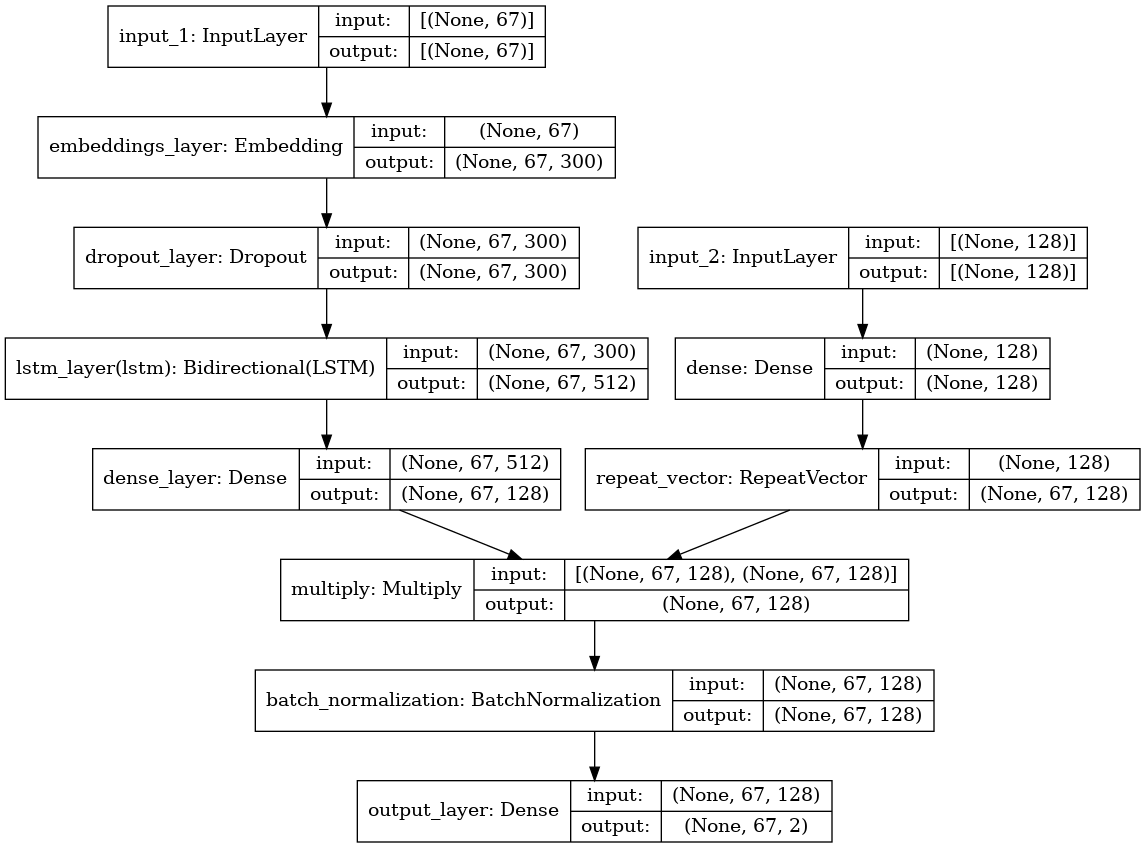

In [33]:
# A plot for the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [34]:

valid_preds_array = np.zeros((len(train_df), 5*max_len)) # an array for model predictions on validation (5 because for each fold we run the model 5 times) 
accs = [] # list for mean f1 score on each fold
accs_dict = dict()
for fold in range(10): # loop through each fold this fold will be for validation and other 9 folds for training 
    for ind in range(5): # for each fold train and predict 5 times to get the best result
        print('-'*40, '>', f'Fold {fold+1}', '<', '-'*40)
        # split into training and validation based on fold (x is text, y is sequence labeling ) 
        x_train_1, x_train_2, y_train = train_df[train_df['fold'] != fold]['text'], train_df[train_df['fold'] != fold][map(str, list(range(128)))], train_df[train_df['fold'] != fold]['seq']
        x_valid_1, x_valid_2, y_valid = train_df[train_df['fold'] == fold]['text'], train_df[train_df['fold'] == fold][map(str, list(range(128)))].values, train_df[train_df['fold'] == fold]['seq']
        spans_true = train_df[train_df['fold'] == fold]['spans'] # ground truth spans of validation fold (To calculate F1 on val fold)
        x1, y1 = encoding(x_train_1, y_train) #(encoding token to index of token)
        x2, y2 = encoding(x_valid_1, y_valid) # (encoding token to index of token)
        with tpu_strategy.scope():
            model = multi_input_model()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
                          loss={'output_layer': 'categorical_crossentropy'}, 
                          metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])
        # saving best model to use for prediction
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        filepath = f'./best_model_fold{fold+1}.h5'
        checkpointer = ModelCheckpoint(filepath=filepath ,
                           verbose=1,
                           mode='auto',
                           save_best_only=True,
                           save_weights_only=True,
                           monitor='val_accuracy')
        # using an adaptive learning rate that decreases when val loss platueas
        lr = tf.keras.callbacks.ReduceLROnPlateau(
                                        monitor="val_accuracy",
                                        factor=0.5,
                                        patience=3,
                                        verbose=1,
                                        mode="auto",
                                        min_lr=1e-6)
        # fitting the model
        model.fit([x1, x_train_2], np.array(y1), batch_size=64, epochs=50, validation_data=([x2, x_valid_2], np.array(y2)), 
        callbacks=[lr, checkpointer])
        # loading best model's weights
        model.load_weights(filepath)
        y_pred = model.predict([x2, x_valid_2], batch_size=64) # using best model to predict val fold
        y_pred = np.argmax(y_pred, axis=-1) # # converting predictions into sequence of ones and zeros corresponding to words

        # return back
        valid = [[idx2word[i] for i in row] for row in x2]
        raw_y = decoding(x_valid_1.values, x2, y_pred)  # using decode function to extract toxic spans based on labels predicted by model

        acc = []
        for i in range(0, len(y_valid)): # looping through all validation examples in fold
            acc.append(f1(raw_y[i], spans_true.values[i])) # calculating F1 score between ground truth spans and predicted spans and appending score to scores list

        accs.append(np.mean(acc)) # appending mean f1 score for fold to list accs (5 f1 scores per fold)
        print(np.mean(acc)*100)
        valid_preds_array[train_df['fold'] == fold, ind*max_len:ind*max_len+max_len] += y_pred
    accs_dict[f'fold {fold+1}'] = accs # associating each fold with its final f1 score
    accs = []

---------------------------------------- > Fold 1 < ----------------------------------------
Epoch 1/50
26/26 [==============================] - 15s 267ms/step - loss: 0.6924 - accuracy: 0.6173 - val_loss: 0.7170 - val_accuracy: 0.2381

Epoch 00001: val_accuracy improved from -inf to 0.23814, saving model to ./best_model_fold1.h5
Epoch 2/50
26/26 [==============================] - 1s 45ms/step - loss: 0.5323 - accuracy: 0.9451 - val_loss: 0.5054 - val_accuracy: 0.9905

Epoch 00002: val_accuracy improved from 0.23814 to 0.99046, saving model to ./best_model_fold1.h5
Epoch 3/50
26/26 [==============================] - 1s 45ms/step - loss: 0.3928 - accuracy: 0.9811 - val_loss: 0.3402 - val_accuracy: 0.9902

Epoch 00003: val_accuracy did not improve from 0.99046
Epoch 4/50
26/26 [==============================] - 1s 44ms/step - loss: 0.2668 - accuracy: 0.9909 - val_loss: 0.2216 - val_accuracy: 0.9902

Epoch 00004: val_accuracy did not improve from 0.99046
Epoch 5/50
26/26 [================

In [35]:
# print accuracies dictionary which contains the folds and the corresponding accuracies
max_accs = []
for key, values in accs_dict.items():
    print(key, np.argmax(values), np.max(values), values)
    max_accs.append(np.max(values))

fold 1 2 0.8363599610848748 [0.8162669118356572, 0.8126069716034899, 0.8363599610848748, 0.8225048798888867, 0.8203369365702968]
fold 2 4 0.8612401899117585 [0.8553796697130032, 0.8461922182755515, 0.8594376611043278, 0.8564797594394071, 0.8612401899117585]
fold 3 1 0.8498515781043712 [0.8383803925987149, 0.8498515781043712, 0.8135319898826091, 0.8262910805909863, 0.8279040197661479]
fold 4 3 0.8230342954259362 [0.8100893886433104, 0.801991608265843, 0.8209529783131219, 0.8230342954259362, 0.815765743206023]
fold 5 1 0.825887495277274 [0.8185559197172672, 0.825887495277274, 0.8169700426279374, 0.8166614006526288, 0.817869291530639]
fold 6 4 0.8155092431332983 [0.8087092216701155, 0.7987561858790909, 0.8041542941600736, 0.8002294110017035, 0.8155092431332983]
fold 7 3 0.8337537915837673 [0.7965495573826571, 0.8172426092178506, 0.8312964194345541, 0.8337537915837673, 0.7972268677599053]
fold 8 4 0.7907506708023202 [0.7756808067457327, 0.7907033883449821, 0.7805196763092488, 0.78621709521

In [36]:
print("Mean F1 =", np.mean(max_accs))
print("Std F1 =", np.std(max_accs, ddof=1))

Mean F1 = 0.8288907371784775
Std F1 = 0.02092256969759571


In [37]:
pd.DataFrame(valid_preds_array, columns=[f'{i}' for i in range(valid_preds_array.shape[1])]).to_csv('oof_preds.csv', index=False)

In [38]:
with open("accs_dict.txt", "w") as file:
    file.write(f'{accs_dict}')